# Qualitative Analysis

Author: Serena

In relation to the driving question, we also want to use human intuition to compare the impacts of different measures. The way we go about doing that is examining the seasonality plots and identifying patterns which may be difficult to capture in simple machine learning models. 

Goals
- Get an understanding of the patterns in each user we have data for atm
- Develop functions to plot seasonality plots for different time frames and step measures

In [145]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [21]:
# Data reading functions authored by Martin, copied and pasted here

def read_QS_data(filename):
    #Read in CSV file
    dat = pd.read_csv(filename)
    #Extract datetime information
    dat["Datetime"] = pd.to_datetime(dat["Start"], format = '%d-%b-%Y %H:%M')
    dat["Date"] = dat["Datetime"].dt.date
    dat["Hour"] = dat["Datetime"].dt.hour
    #Format columns
    dat = dat[["Date", "Hour", "Steps (count)"]]
    dat.columns = ["Date", "Hour", "Steps"]
    
    return dat

def read_Pacer_data(filename):
    #Read in the data
    dat = pd.read_csv(filename)
    #Select necessary columns
    dat = dat[["date","steps"]]
    #Extract datetime data
    dat["datetime"] = pd.to_datetime(dat["date"], format = '%m/%d/%Y, %H:%M:%S %z')
    dat["Date"] = dat["datetime"].dt.date
    dat["Hour"] = dat["datetime"].dt.hour
    dat["Min"] = dat["datetime"].dt.minute
    #Aggregate over the hours
    dat = dat.groupby(["Date","Hour"])["steps"].agg("sum").reset_index()
    #Relabel columns
    dat.columns = [["Date", "Hour", "Steps"]]
    
    return dat




Reading in one data file to help develop the functions (an extension of `adherenceComp_V1_SG_25102020.ipynb`)

In [22]:
data = read_QS_data("../../data/SUSS.csv")
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data.head()

,Date,Hour,Steps
0,2015-11-28,12,13.0
1,2015-11-28,13,19.0
2,2015-11-28,14,33.0
3,2015-11-28,15,80.0
4,2015-11-28,16,0.0


In [200]:
def process_dfs(df, resample_by, plot_by):
    if str(df['Date'].dtype) != 'datetime64[ns]':
        df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    
    tl = {'month': 'm', 'year':'A', 'day': 'd', 'week':'W', 'hour': 'H'}
    
    resampled = df.resample(tl[resample_by], on='Date')
    aggregates =  resampled.agg({'Hour': 'count', 'Steps': 'sum'})
    
    plot_by = plot_by.strip().lower()
    
    aggregates['year'] = aggregates.index.year
    aggregates['month'] = aggregates.index.month_name()
    aggregates['week'] = aggregates.index.week
    aggregates['day'] = aggregates.index.day
    aggregates['hour'] = aggregates.index.hour
    aggregates['dow'] = aggregates.index.dayofweek
    aggregates['weekday'] = aggregates['dow'].apply(lambda x: True if x <= 4 else False)

    return aggregates

def seasonality_plot(dfs, resample_by, plot_by, colour_by=None, custom_title=None):
    """
    Resamples step data and plots by the time period given.
    :param: dfs - a dictionary with the labels as keys and df as values
    """

    results = defaultdict(list)
    
    n = 0
    max_uniques = 0;
    
    for lab in dfs:
        df = dfs[lab]
        
        aggregates = process_dfs(df, resample_by, plot_by)

        if plot_by == 'year':
            uniques = aggregates['year'].unique()
        elif plot_by == 'month':
            uniques = aggregates['month'].unique()

        elif plot_by == 'week':
            uniques = aggregates['week'].unique()
        else:
            print(f"Plot_by not supported: {plot_by}")

        results[n].append(aggregates)
        results[n].append(uniques)
        results[n].append(lab)
        
        max_uniques = max(max_uniques, len(uniques))
        n += 1
        
    WIDTH = len(results)*5
    HEIGHT = len(results)*18
    
    top = cm.get_cmap('viridis', 128)
    bottom = cm.get_cmap('Blues', 128)
    newcolors = np.vstack((top(np.linspace(0.25, 0.75, 128)),
                       bottom(np.linspace(0.25, 0.75, 128))))
    newcolors = top(np.linspace(0.2, 0.9, 50))
    CMAP = ListedColormap(newcolors, name='OrangeBlue')
#     CMAP = 'summer'
    
    # Plot data
    fig, axs = plt.subplots(max_uniques, len(dfs), sharex = True, sharey=True, 
                            figsize=(WIDTH, HEIGHT))
    plt.subplots_adjust(hspace=0.2, wspace = 0)
    
    for n in results:
        uniques = results[n][1]
        aggregates = results[n][0]
        lab = results[n][2]
        
#         print(n)
        for i, y in enumerate(uniques):
            axs[i, n].scatter(aggregates[aggregates[plot_by] == y][resample_by], 
                           aggregates[aggregates[plot_by] == y]['Steps'],
                           c=aggregates[aggregates[plot_by] == y][colour_by] if colour_by is not None else colour_by,
                              s=20, cmap=CMAP
                          )
            axs[i, n].plot(aggregates[aggregates[plot_by] == y][resample_by], 
                        aggregates[aggregates[plot_by] == y]['Steps'] )
            axs[i, n].grid()

            if i ==0:
                axs[i, n].set_title(lab)
            
            if n == len(results) - 1:
                axs[i, n].text(1.02, 0.5, y , size=12,
                           verticalalignment='center', rotation=270, transform=axs[i, n].transAxes)
    
            axs[i, n].xaxis.set_tick_params(which='both', labelbottom=True) # Bring xlabels back to inner plots
    
    plt.suptitle(custom_title if custom_title else f"Seasonal Plot of {resample_by} Steps Grouped By {plot_by} - Time Series ", 
                 fontsize=20, y= 0.90)
    fig.text(0.5, 0.04, resample_by, ha='center')
    fig.text(0.04, 0.5, "Step Count", va='center', rotation='vertical')
    
    plt.show()

Running the seasonality plot:
- resample by `day` and plot by `month`, colour `weekday`
- resample by `month` and plot by `year`

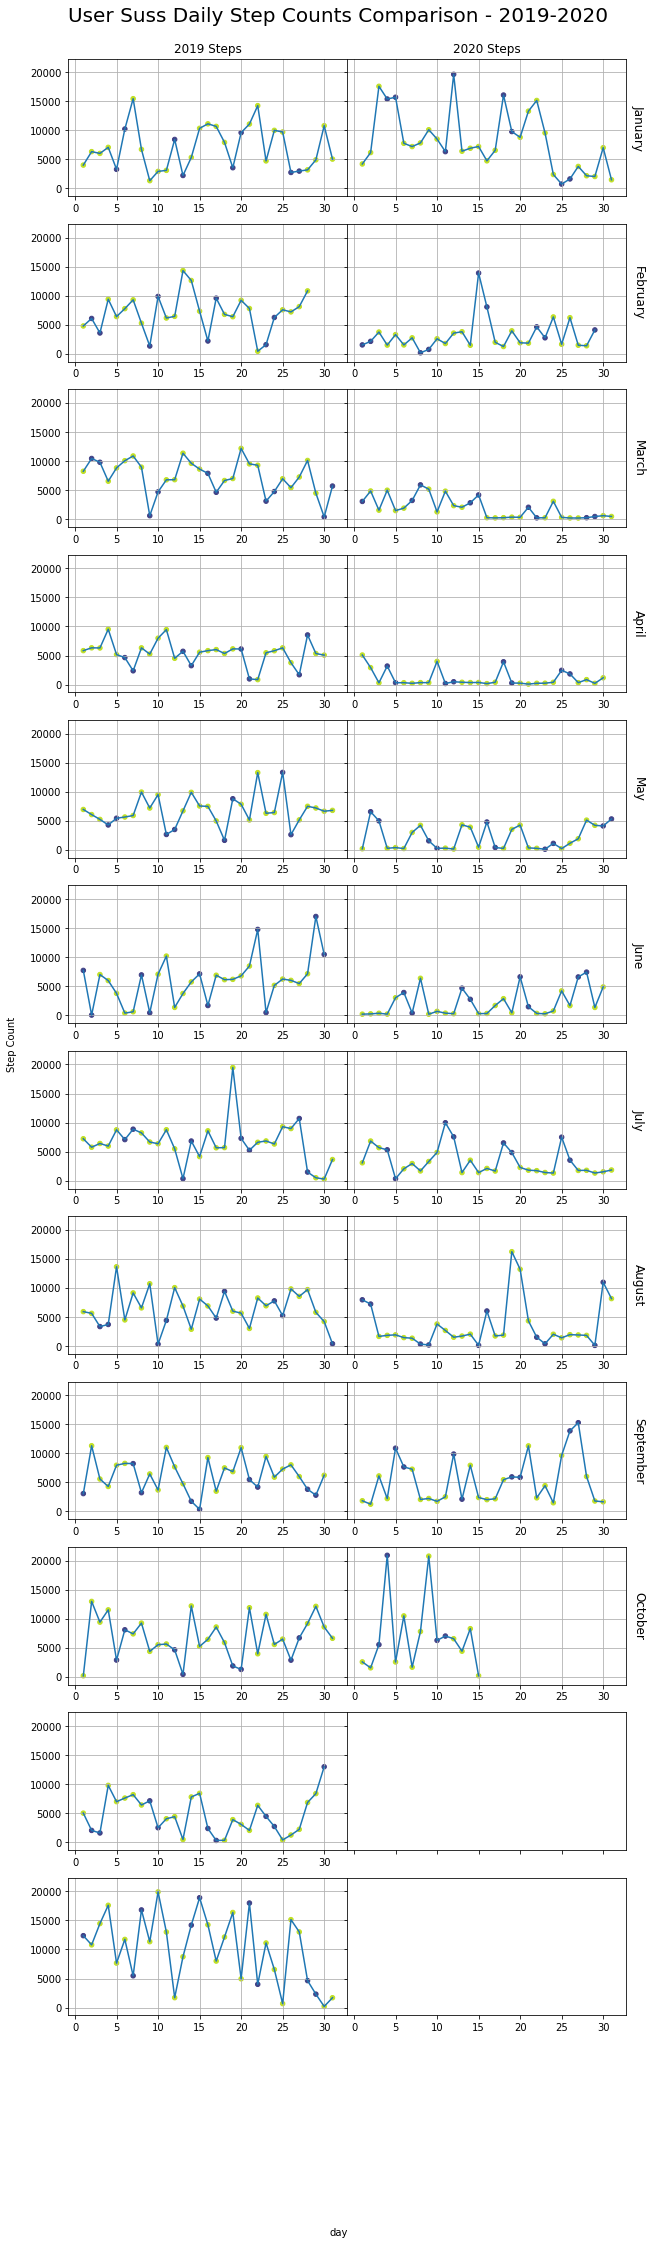

In [201]:
plot_res = {
    '2019 Steps': data[data['Date'].dt.year == 2019], 
    '2020 Steps': data[data['Date'].dt.year == 2020]
}
seasonality_plot(plot_res, 'day', 'month', 
                 colour_by='weekday', custom_title='User Suss Daily Step Counts Comparison - 2019-2020')




---
Reading in the rest of the data

Comparing user1 to themselves over 2017-2019.

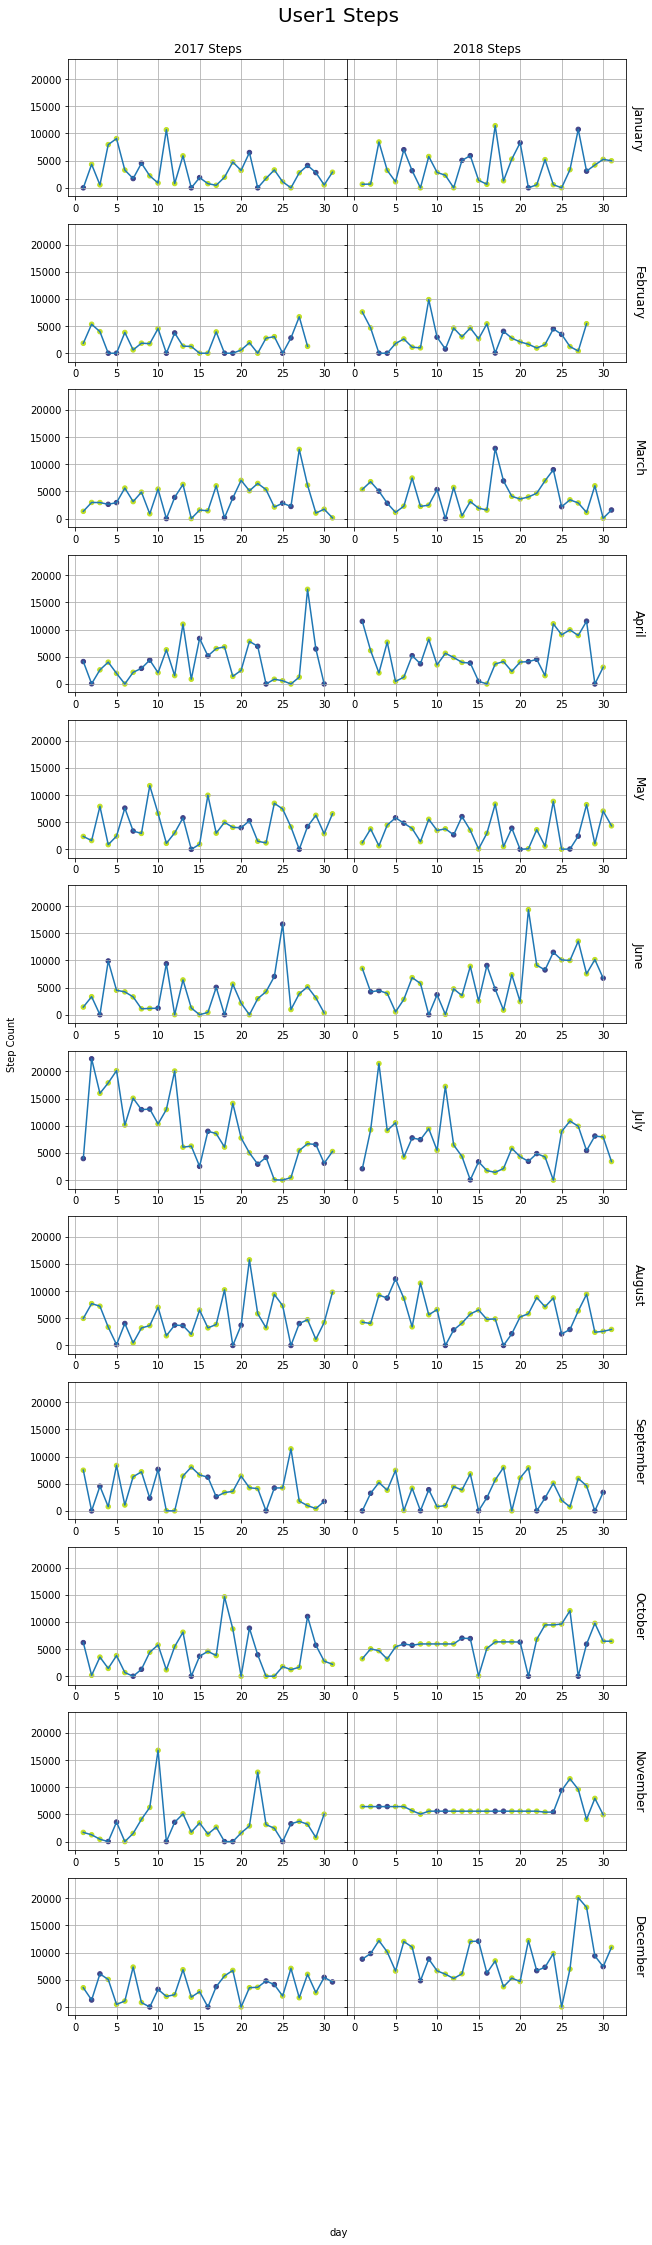

In [202]:
user1_data = read_QS_data("../../data/User1.csv")
user1_data['Date'] = pd.to_datetime(user1_data['Date'], format='%Y-%m-%d')
user1_res = {
    '2017 Steps': user1_data[user1_data['Date'].dt.year == 2017],
    '2018 Steps': user1_data[user1_data['Date'].dt.year == 2018]
}
seasonality_plot(user1_res, 'day', 'month', 'weekday', custom_title = "User1 Steps")


We can see that their activity seems to have increased over the years, but their overall activity decreases over the length of the year. 

Comparing User_SUSS to User1:

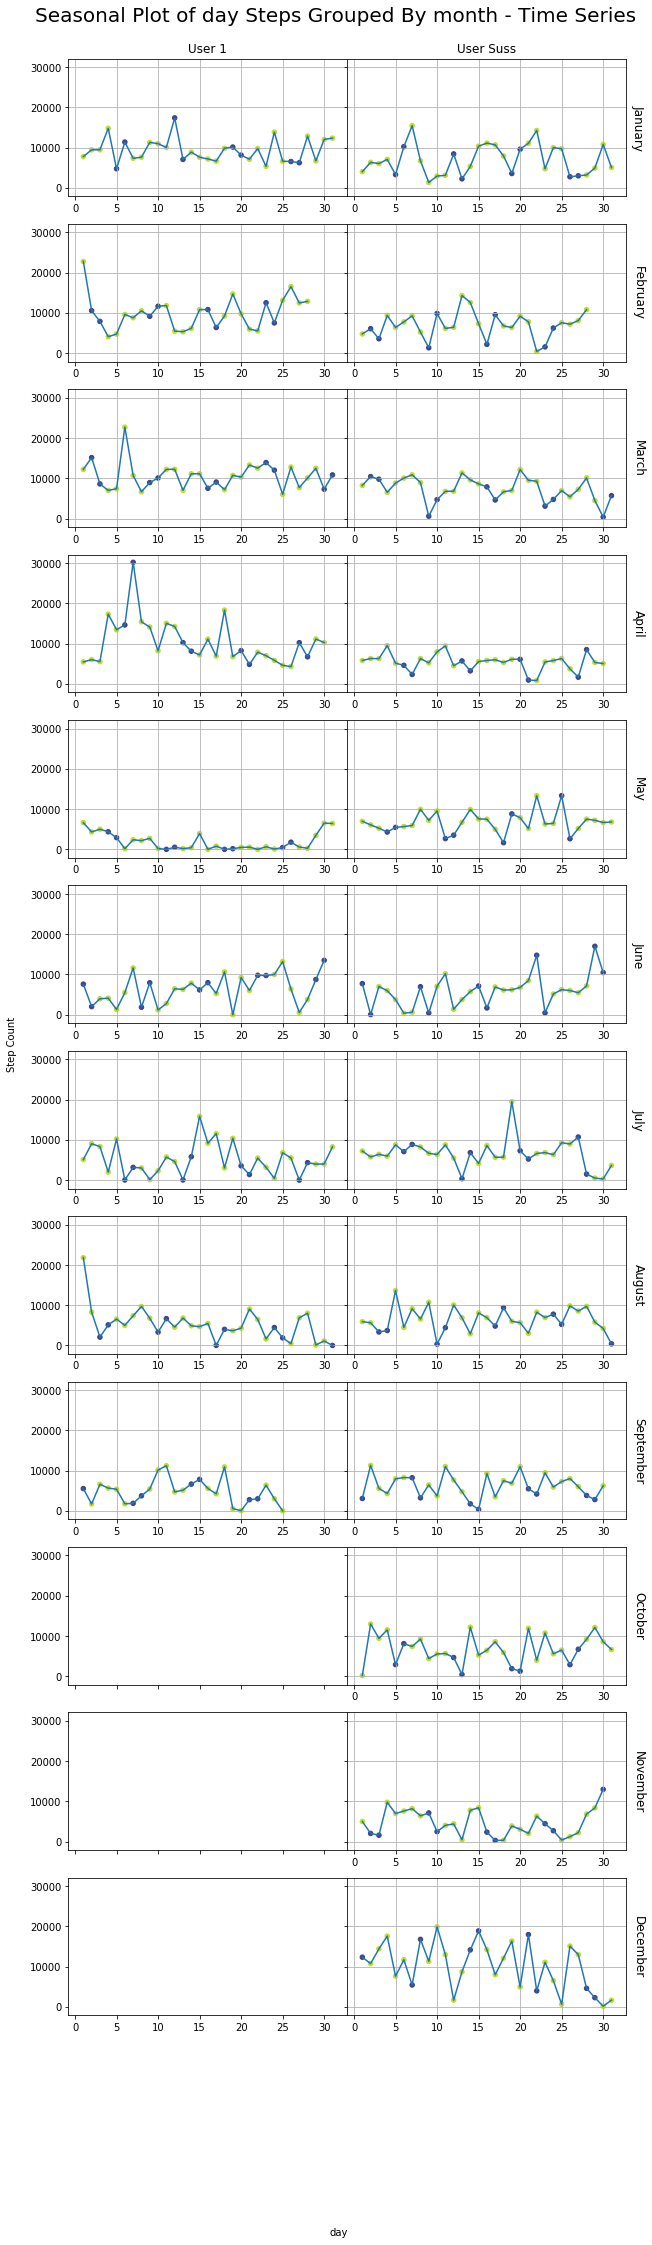

In [204]:

seasonality_plot({ 'User 1': user1_data[user1_data['Date'].dt.year == 2019],
                  'User Suss': data[data['Date'].dt.year == 2019]}
                 , 'day', 'month', 'weekday')

From this, we can see that User1 (left) and User SUSS (right) have fairly similar baseline levels of activity, with exceptions being April, where 1 walked much more than Suss, and May, where Suss walked more than 1. 

In [16]:
user2_data = read_QS_data("../../data/User2.csv")
user2_data['Date'] = pd.to_datetime(user2_data['Date'], format='%Y-%m-%d')

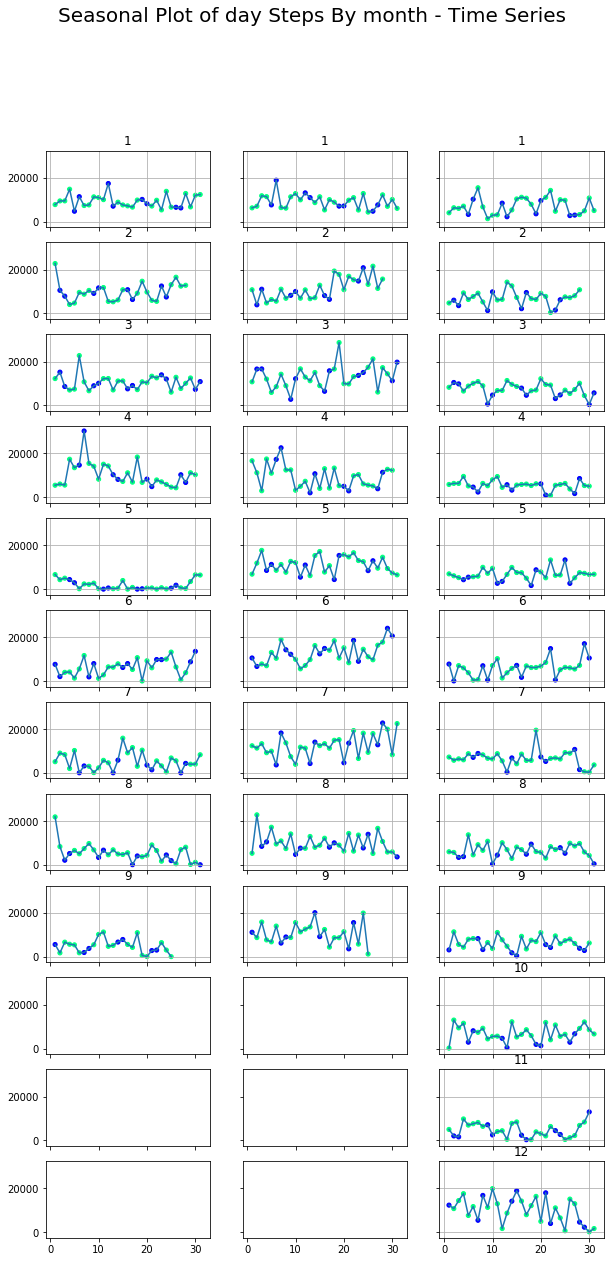

In [17]:
seasonality_plot([user1_data[user1_data['Date'].dt.year == 2019],
                  user2_data[user2_data['Date'].dt.year == 2019],
                  data[data['Date'].dt.year == 2019]
                 ], 'day', 'month', 'weekday')

When we add User2 into the mix, it's clear that User2 walks the most out of the three users so far. 

This function will be useful in comparing the different adherence measures.

